### Imports

In [691]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [692]:
%autoreload 2

In [693]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [694]:
connection = Connection()
# Get client
client = connection.get_client()

In [695]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [696]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [697]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
[Non-physical filter] Rows before: 100, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 98
W06 Record count after preprocessing: 98
W08 original record count: 69
[Non-physical filter] Rows before: 66, dropped: 10 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 56
W08 Record count after preprocessing: 56
W10 original record count: 222
[Non-physical filter] Rows before: 221, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 219
W10 Record count after preprocessing: 219
W11 original record count: 154
[Non-physical filter] Rows before: 119, dropped: 0 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 119
W11 Record coun

723

In [698]:
df_all_wells_preprocessed["pres_drop"].describe()

count    723.000000
mean     104.623834
std        8.451487
min       66.960966
25%      100.268370
50%      103.942967
75%      109.984311
max      183.323377
Name: pres_drop, dtype: float64

In [699]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          28
qg_mpfm          28
qw_mpfm          28
wc_mpfm           0
gor_mpfm         30
wgr_mpfm         31
gor_well_test     0
wgr_well_test     0
pres_drop         0
temp_drop         0
well_id           0
time_idx          0
dtype: int64

In [700]:
df_all_wells_preprocessed[df_all_wells_preprocessed["well_id"] == "W06"]["qg_well_test"].describe()

count       98.000000
mean     15289.766695
std       4450.432032
min       4808.909153
25%      12326.947029
50%      16413.557469
75%      18801.713901
max      22675.337981
Name: qg_well_test, dtype: float64

In [770]:
# df_train, df_val, df_test = get_temporal_split_per_well(df=df_all_wells_preprocessed, val_frac=0.1, test_frac=0.2)
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=497, Validation=71, Test=155


In [771]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [772]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [773]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
assert_model(model)

[INFO] Regime below_normal: 54 samples
[INFO] Regime normal: 332 samples
[INFO] Regime above_normal: 82 samples
[INFO] Validation ML usage fraction: 1.00


In [774]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.9069178140469952,
   'mae': 8.784044024454067,
   'rmse': 11.177563758668725,
   'mape (%)': 10.417953391884508,
   'mpe (%)': 7.466817356998999},
  'qw': {'r2': 0.0119073890254765,
   'mae': 0.7290768198808336,
   'rmse': 0.8868769875516532,
   'mape (%)': 500.1223977185944,
   'mpe (%)': 487.39788259833057},
  'qg': {'r2': 0.630796836828635,
   'mae': 2302.491536428799,
   'rmse': 2833.83263813671,
   'mape (%)': 15.192327747833534,
   'mpe (%)': -7.511124754395385},
  'wgr': {'r2': -2.204412410984888,
   'mae': 6.336365229280024e-05,
   'rmse': 8.945343740126301e-05,
   'mape (%)': 337.8634360233468,
   'mpe (%)': 326.66266131882395},
  'gor': {'r2': -143.13835854247424,
   'mae': 19.973497388236122,
   'rmse': 25.278553687634517,
   'mape (%)': 16.08323870435663,
   'mpe (%)': -12.89437930842193}},
 'W08': {'qo': {'r2': -0.31804186541768553,
   'mae': 8.010091832707538,
   'rmse': 9.759490298015963,
   'mape (%)': 27.212846237317912,
   'mpe (%)': -0.7741094

In [775]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9504803827956879,
   'mae': 6.267471673396943,
   'rmse': 8.15271965025549,
   'mape (%)': 5.86894958601682,
   'mpe (%)': 3.4114792800768114},
  'qw': {'r2': -1.4596054417376583,
   'mae': 1.0779094942010436,
   'rmse': 1.399256338471834,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8762511478128022,
   'mae': 1149.07871277503,
   'rmse': 1640.6354109313324,
   'mape (%)': 9.408283871920247,
   'mpe (%)': 6.904425184699702},
  'wgr': {'r2': -2.572962638847643,
   'mae': 8.015665236403292e-05,
   'rmse': 9.445763521762716e-05,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -34.91628856609339,
   'mae': 10.211982727281569,
   'rmse': 12.618512500230652,
   'mape (%)': 8.286581850076624,
   'mpe (%)': 3.333887548541517}},
 'W08': {'qo': {'r2': 0.36634363040114304,
   'mae': 5.404598577858987,
   'rmse': 6.766894981360047,
   'mape (%)': 16.77873123850717,
   'mpe (%)': -15.251114081338867},
  'qw': {'r2': 0.5800290225033339,
   'mae'

In [776]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9699585900778159,
   'mae': 4.453405572843232,
   'rmse': 6.350004377052957,
   'mape (%)': 3.2906822907966524,
   'mpe (%)': 3.2906822907966524},
  'qw': {'r2': -1.1527466144039518,
   'mae': 0.9906465232958023,
   'rmse': 1.309064416088374,
   'mape (%)': 91.80067191230152,
   'mpe (%)': -73.73340117103142},
  'qg': {'r2': 0.9725441396232847,
   'mae': 510.1189172312389,
   'rmse': 772.7855985962353,
   'mape (%)': 3.586871285369355,
   'mpe (%)': 3.586871285369355},
  'wgr': {'r2': -2.2091158572627125,
   'mae': 7.406856489759789e-05,
   'rmse': 8.95190633422763e-05,
   'mape (%)': 87.3482361268277,
   'mpe (%)': -87.3482361268277},
  'gor': {'r2': -6.640221597967019,
   'mae': 3.812307860510429,
   'rmse': 5.819898542528183,
   'mape (%)': 3.0563529359785746,
   'mpe (%)': 0.3518742881258417}},
 'W08': {'qo': {'r2': 0.8729644312151503,
   'mae': 2.5084414421943246,
   'rmse': 3.0298784228702518,
   'mape (%)': 10.147854724979085,
   'mpe (%)': 5.581464162804

In [777]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

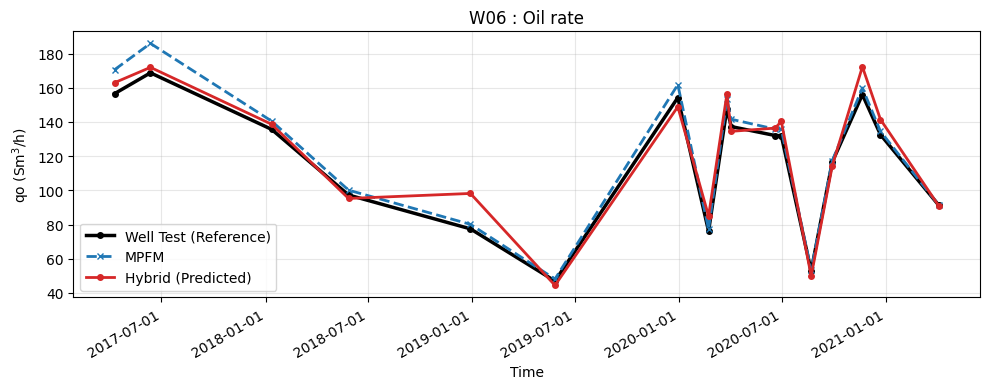

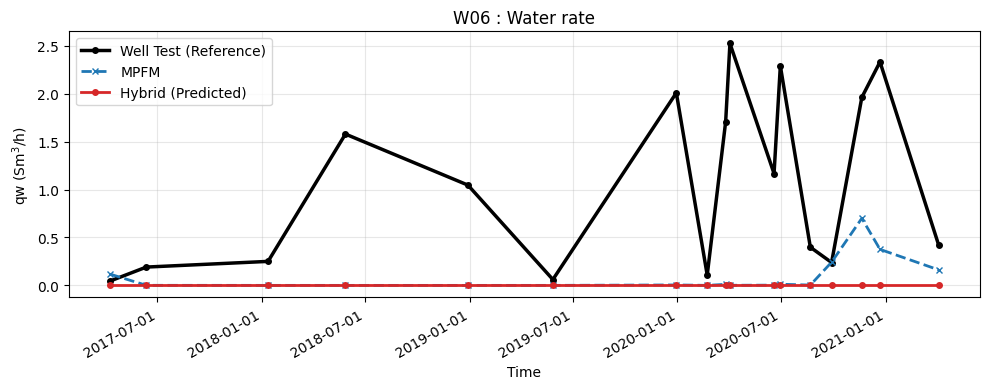

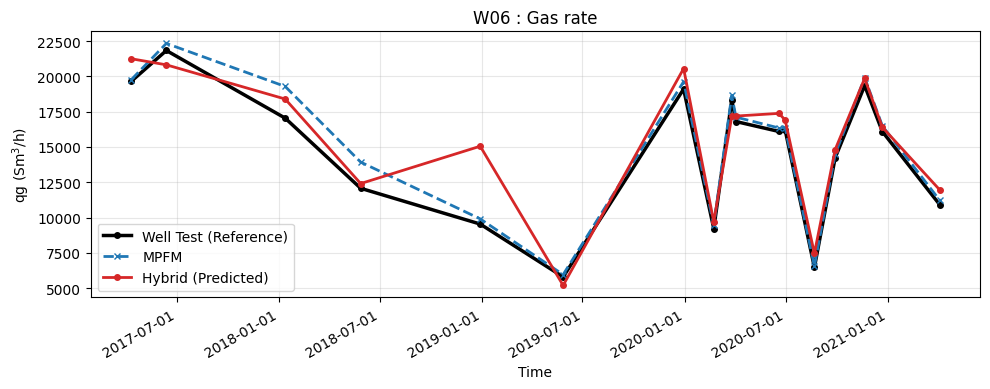

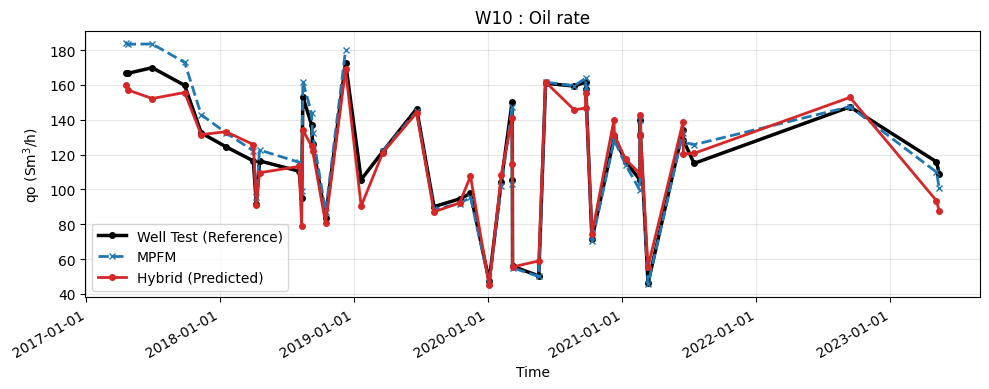

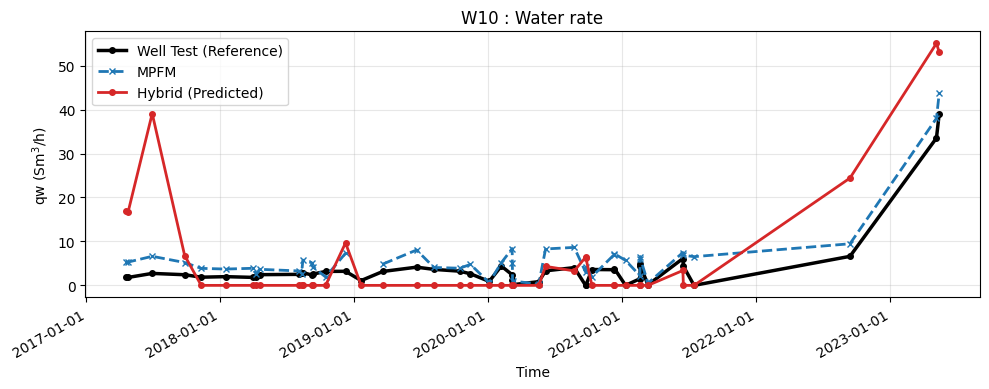

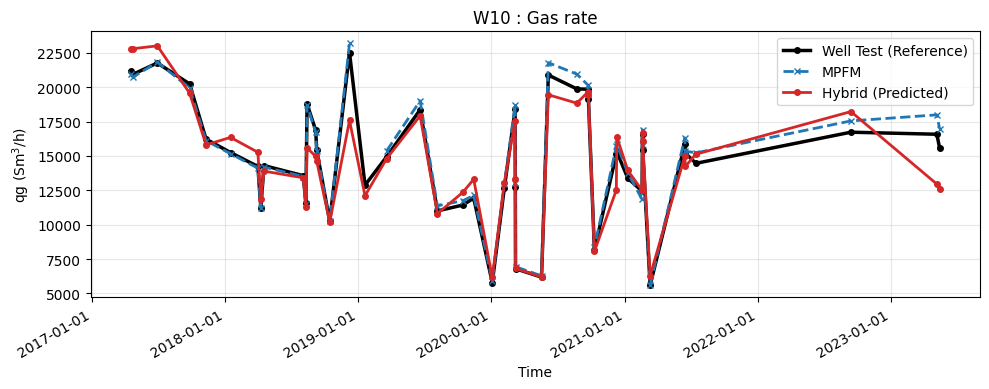

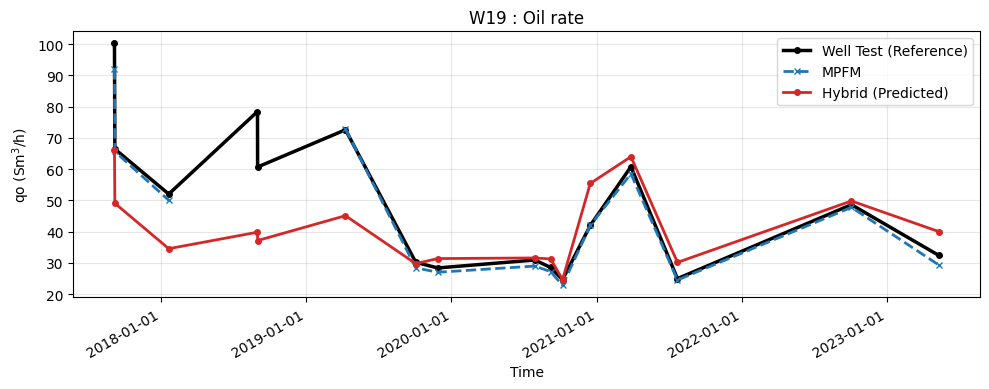

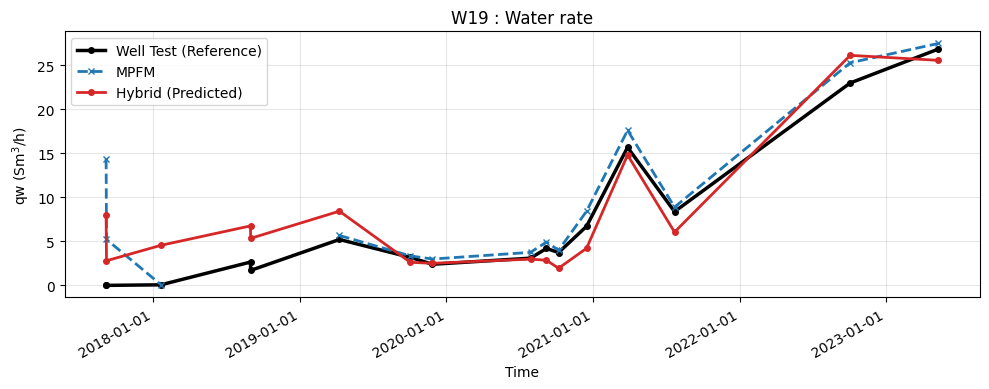

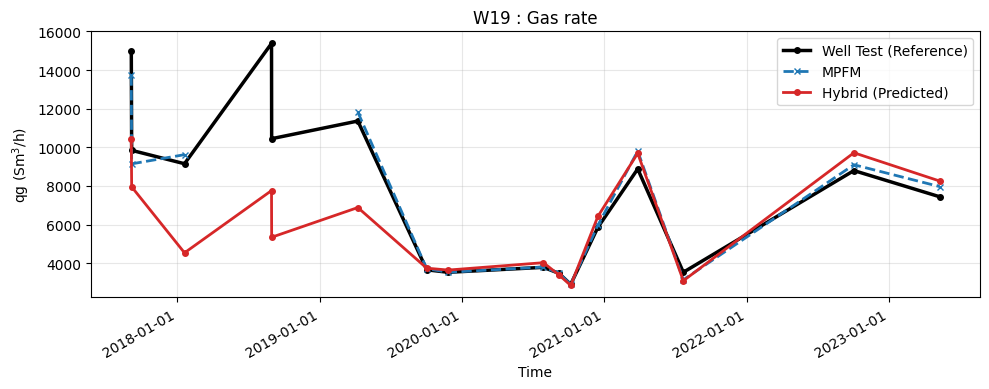

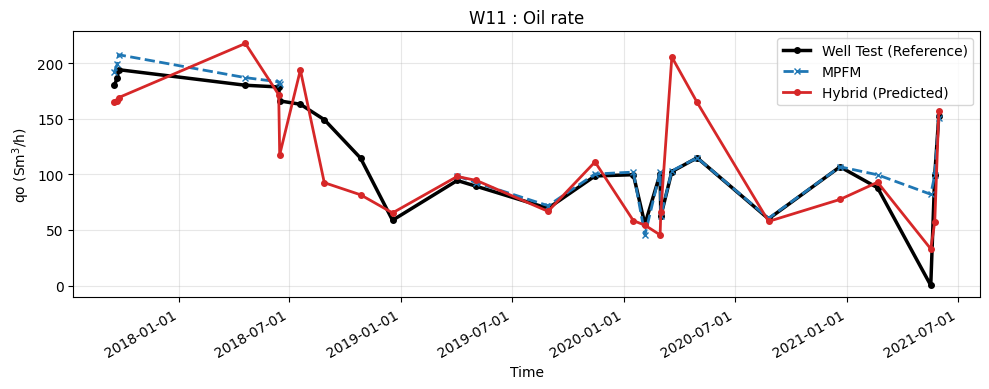

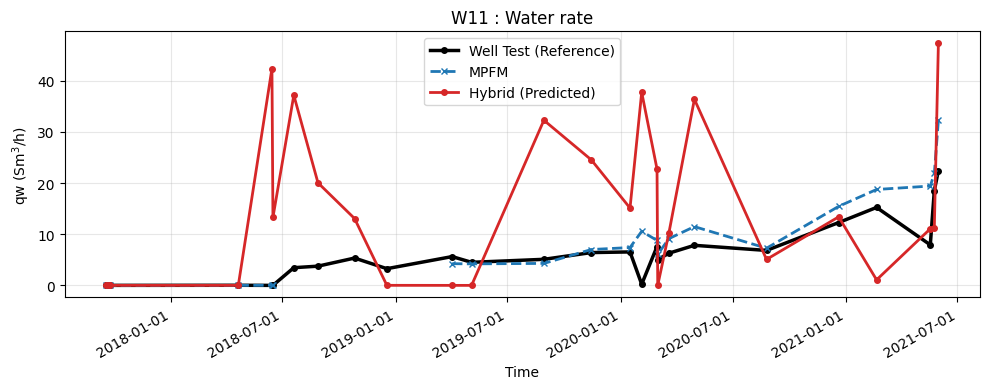

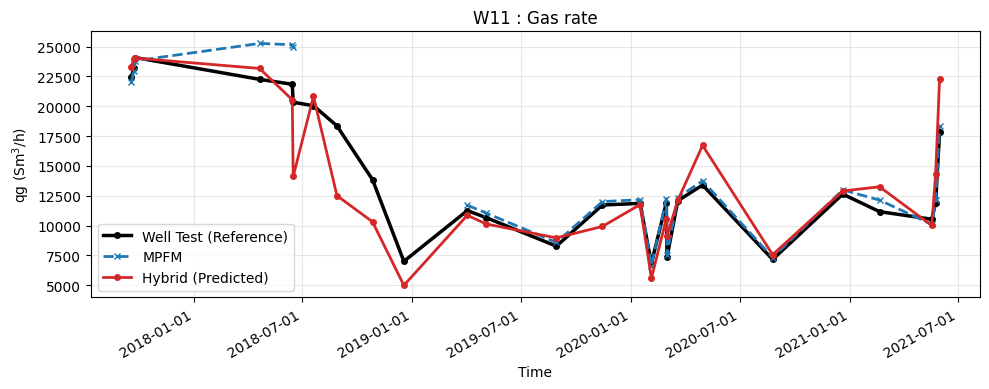

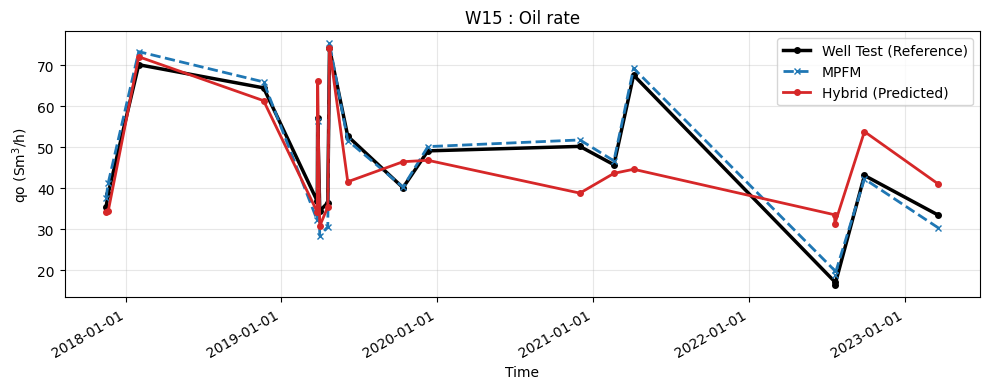

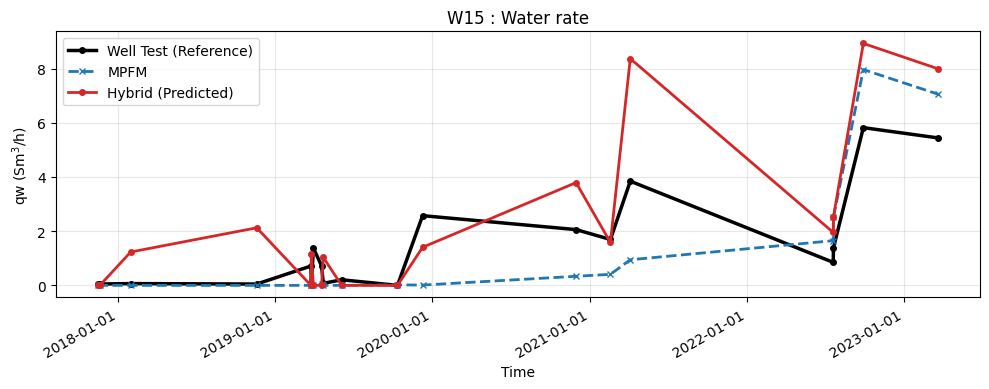

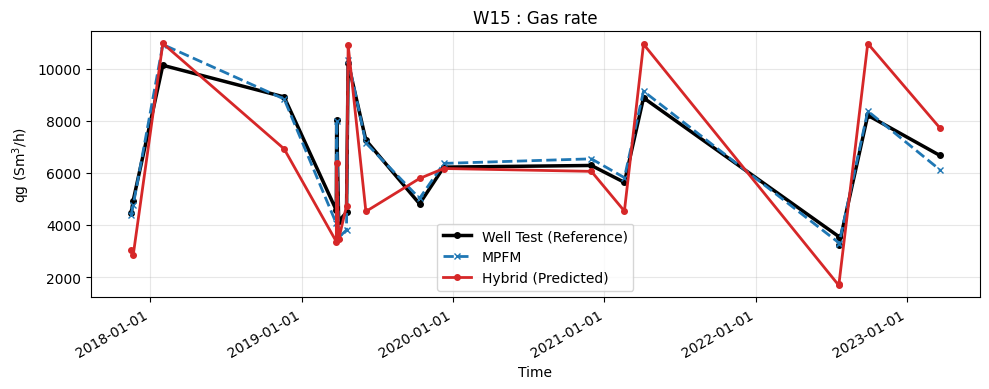

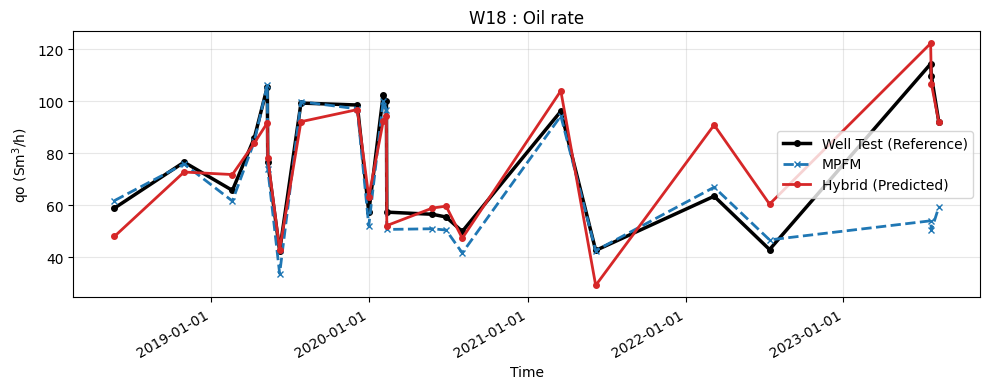

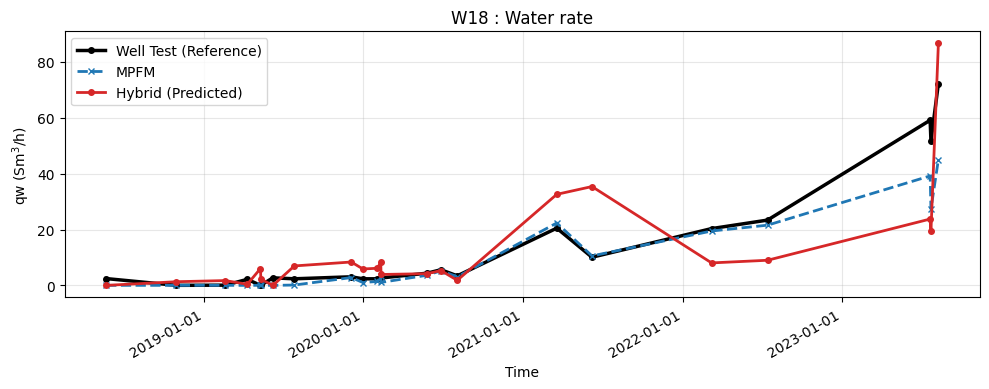

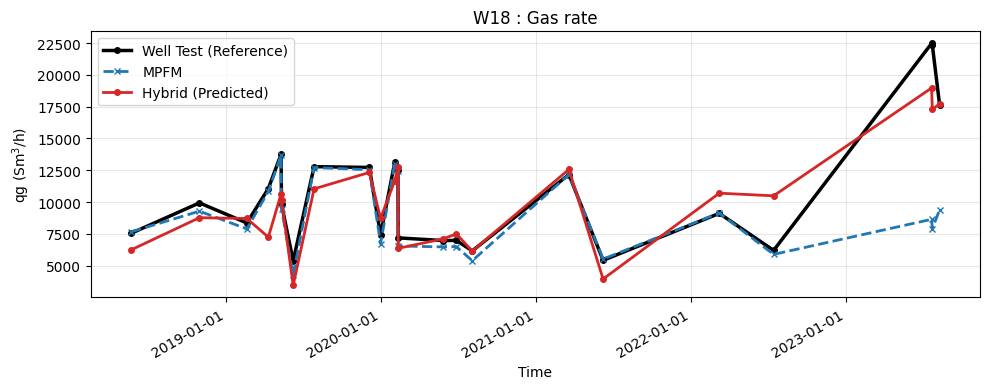

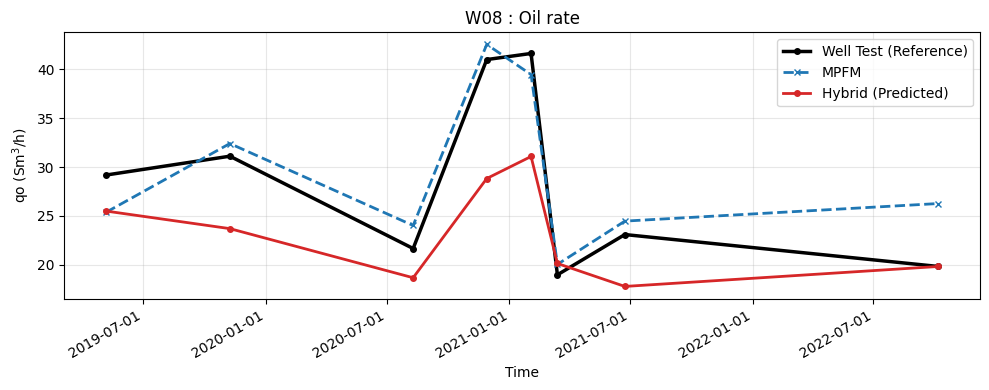

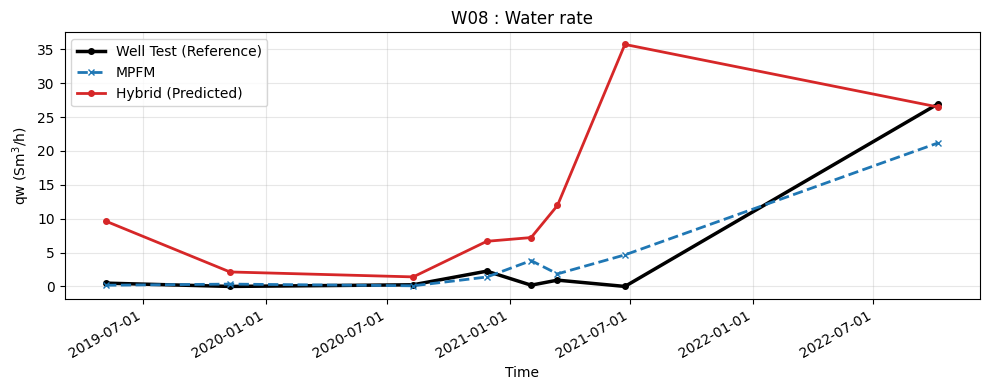

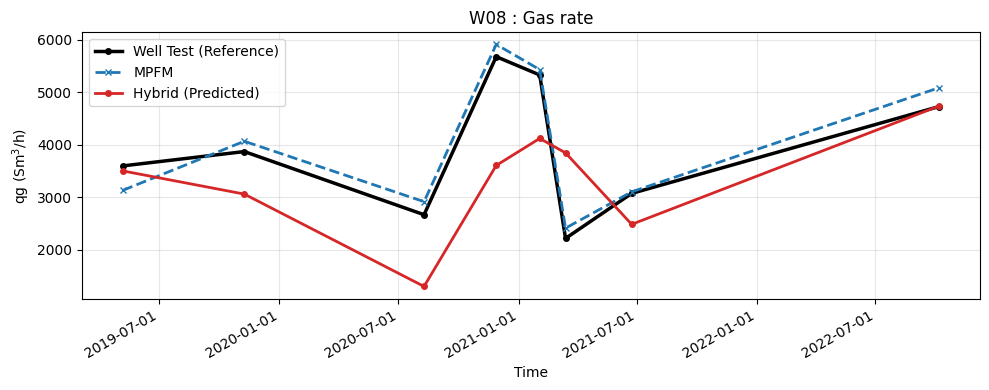

In [778]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [821]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10", is_random_ordered=True)
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=400, Val=104, Calibration=20, Test=199


In [822]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[INFO] Regime below_normal: 60 samples
[INFO] Regime normal: 218 samples
[INFO] Regime above_normal: 91 samples
[INFO] Validation ML usage fraction: 1.00


In [823]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)
assert_model(model_lowo)

In [824]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.4313651925100763,
   'mae': 15.563193616416516,
   'rmse': 23.70624761464924,
   'mape (%)': 16.884782026890775,
   'mpe (%)': 8.16340516028581},
  'qw': {'r2': 0.5827980272042308,
   'mae': 3.257839264318349,
   'rmse': 6.855305144465501,
   'mape (%)': 20954.298530082477,
   'mpe (%)': 20863.995207010164},
  'qg': {'r2': 0.4215934722881457,
   'mae': 2235.1832056269623,
   'rmse': 2903.5313332077712,
   'mape (%)': 14.79389577614016,
   'mpe (%)': -4.089306346592089},
  'wgr': {'r2': 0.3613448387326206,
   'mae': 0.0003003371683514679,
   'rmse': 0.0007504365188899848,
   'mape (%)': 97.79930168977965,
   'mpe (%)': 7.566577152613895},
  'gor': {'r2': -3.735527208739035,
   'mae': 15.772711283556971,
   'rmse': 21.690223788449213,
   'mape (%)': 12.25733935755405,
   'mpe (%)': -9.096669428159728}}}

In [825]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.6623809320155644,
   'mae': 13.928000891378671,
   'rmse': 18.26667826371083,
   'mape (%)': 14.160365592138533,
   'mpe (%)': 8.703266280721857},
  'qw': {'r2': 0.5515095747454857,
   'mae': 3.793339393011382,
   'rmse': 7.107718219152689,
   'mape (%)': 100.00497089776866,
   'mpe (%)': -46.33730441070016},
  'qg': {'r2': 0.6918902946310215,
   'mae': 1695.5292336322004,
   'rmse': 2119.1544651114395,
   'mape (%)': 13.170194474188676,
   'mpe (%)': 8.960378157056038},
  'wgr': {'r2': 0.48220646915795684,
   'mae': 0.0003007525668221638,
   'rmse': 0.0006757079943912048,
   'mape (%)': 102.92386246676625,
   'mpe (%)': -42.40808007623591},
  'gor': {'r2': -5.376554705426984,
   'mae': 14.173877609306803,
   'rmse': 25.169402719962836,
   'mape (%)': 10.961726379110656,
   'mpe (%)': 2.5126875041189054}}}

In [826]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9566882278155849,
   'mae': 3.949764841949768,
   'rmse': 6.577247029604626,
   'mape (%)': 3.320539378355912,
   'mpe (%)': 1.0571141471420635},
  'qw': {'r2': 0.927022561214878,
   'mae': 2.461917345219791,
   'rmse': 2.894695809571508,
   'mape (%)': 88705.96657111638,
   'mpe (%)': 88695.0237876173},
  'qg': {'r2': 0.9545585030530138,
   'mae': 458.3258228332302,
   'rmse': 817.6802593637364,
   'mape (%)': 3.1266090527982335,
   'mpe (%)': 2.2735894542366966},
  'wgr': {'r2': 0.9494462710234471,
   'mae': 0.0001692689628253526,
   'rmse': 0.000213273285015356,
   'mape (%)': 96.46053591359427,
   'mpe (%)': 84.27383354859607},
  'gor': {'r2': 0.21716294051910812,
   'mae': 6.608851523386723,
   'rmse': 8.905090353318206,
   'mape (%)': 5.146185717890361,
   'mpe (%)': 1.4155165063731492}}}

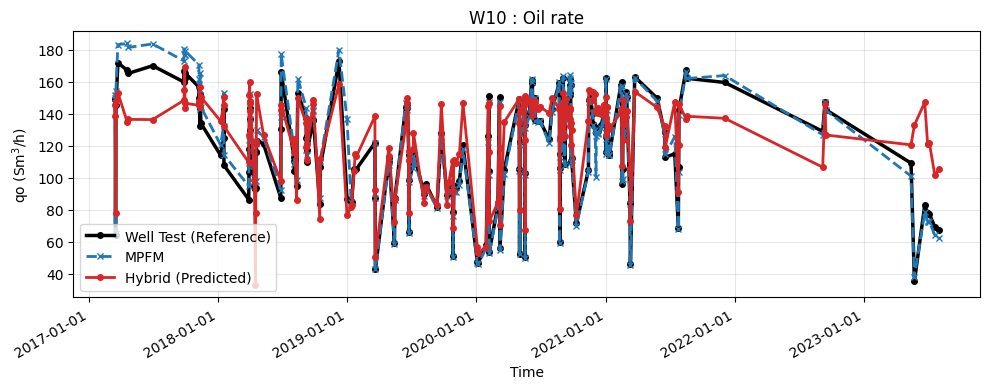

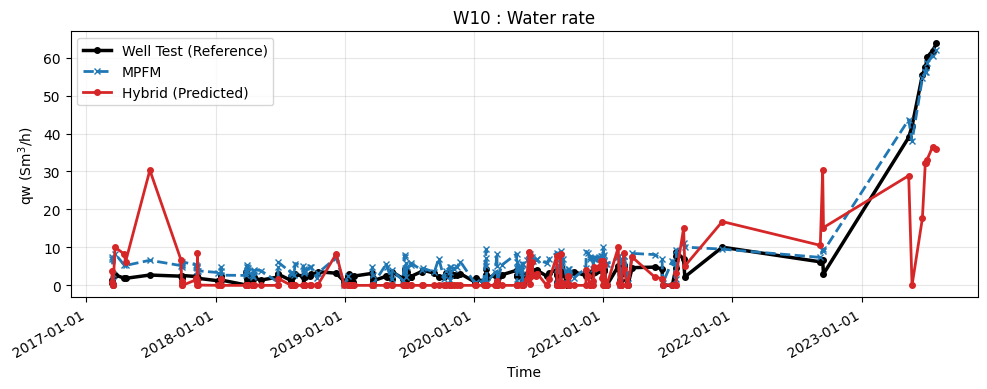

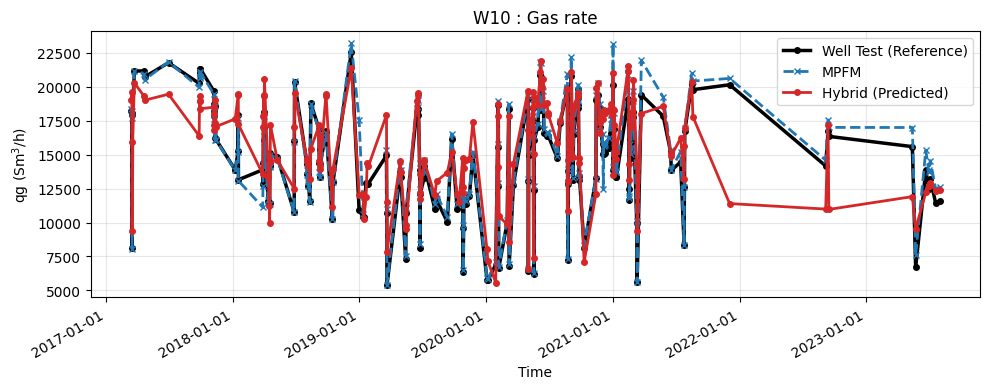

In [827]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [828]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [829]:
# df_resampled.index

In [830]:
# df_resampled.columns

In [831]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [832]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [833]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [834]:
# summarize_null(df_generated)